# 03 - Modelo de Clasificación: K-Nearest Neighbors (KNN)

En este notebook entrenaremos y evaluaremos un modelo de **K-Nearest Neighbors (KNN)**,  
un algoritmo basado en **distancias** que clasifica una observación según las clases  
de sus *K* vecinos más cercanos.

A diferencia de los modelos basados en árboles, KNN **no construye una función explícita de decisión**,  
sino que utiliza toda la base de entrenamiento durante la predicción.  
Por este motivo, **requiere normalización o escalado de los datos**,  
ya que las distancias euclidianas son sensibles a las magnitudes de las variables.



### **Objetivos**

- Cargar los datasets **escalados** (`X_train_scaled.csv`, `X_test_scaled.csv`).  
- Entrenar un modelo base de **KNN** con parámetros por defecto.  
- Evaluar su rendimiento inicial.  
- Aplicar **validación cruzada (Cross-Validation)** para medir estabilidad.  
- Realizar **tuning de hiperparámetros** mediante `GridSearchCV` y `Optuna`.  
- Comparar los resultados entre versiones (baseline, GridSearchCV, Optuna).  
- Guardar los modelos y métricas para comparación posterior.

📌 Este modelo será parte del grupo de algoritmos basados en distancia junto con **SVM**,  
utilizados con datasets escalados para mejorar la homogeneidad de las características.


## **Paso 1: Importación de librerías y carga de datos**

En este primer paso importamos las librerías necesarias y cargamos los datasets escalados  
para el entrenamiento y prueba del modelo **KNN**.

Los datos fueron procesados en el notebook `02_dataset-split.ipynb`.  
Trabajamos con los archivos:

- `X_train_scaled.csv`, `X_test_scaled.csv`  
- `y_train.csv`, `y_test.csv`

El escalado es **imprescindible** para KNN, ya que el algoritmo utiliza distancias euclidianas.


In [16]:
# ===================================
# 1. Importación de librerías y carga de datos
# ===================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import time
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report, RocCurveDisplay
)
from IPython.display import display, Markdown
from math import pi
import warnings

# --- Configuración visual ---
plt.style.use("default")
sns.set_palette("coolwarm")
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")


# --- Cargar datasets escalados ---
X_train = pd.read_csv("../data/processed/X_train_scaled.csv")
X_test = pd.read_csv("../data/processed/X_test_scaled.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").values.ravel()
y_test = pd.read_csv("../data/processed/y_test.csv").values.ravel()

display(Markdown("✅ **Datos cargados correctamente.**"))
display(Markdown(f"- X_train: {X_train.shape}  |  X_test: {X_test.shape}"))


✅ **Datos cargados correctamente.**

- X_train: (83123, 23)  |  X_test: (20781, 23)

## **Paso 2: Entrenamiento del modelo baseline**

Entrenamos un modelo **KNN** con los hiperparámetros por defecto,  
para establecer una línea base de comparación.

Parámetros principales:
- `n_neighbors`: número de vecinos más cercanos.
- `weights`: tipo de ponderación (uniforme o por distancia).
- `metric`: métrica de distancia (euclidiana por defecto).

Se evaluarán las métricas principales sobre el conjunto de test.


In [17]:
# ===================================
# 2. Entrenamiento del modelo baseline
# ===================================

baseline_model = KNeighborsClassifier()
baseline_model.fit(X_train, y_train)

# --- Predicciones ---
y_pred_base = baseline_model.predict(X_test)
y_proba_base = baseline_model.predict_proba(X_test)[:, 1]

# --- Métricas ---
metrics_baseline = {
    "Accuracy": accuracy_score(y_test, y_pred_base),
    "Precision": precision_score(y_test, y_pred_base),
    "Recall": recall_score(y_test, y_pred_base),
    "F1-score": f1_score(y_test, y_pred_base),
    "ROC-AUC": roc_auc_score(y_test, y_proba_base)
}

display(Markdown("### 📊 Métricas del modelo baseline (KNN):"))
display(pd.DataFrame(metrics_baseline, index=["Baseline"]).T)

print(classification_report(y_test, y_pred_base, digits=3))


### 📊 Métricas del modelo baseline (KNN):

,Baseline
Accuracy,0.926471
Precision,0.934861
Recall,0.892504
F1-score,0.913192
ROC-AUC,0.970403


              precision    recall  f1-score   support

           0      0.921     0.952     0.936     11776
           1      0.935     0.893     0.913      9005

    accuracy                          0.926     20781
   macro avg      0.928     0.922     0.925     20781
weighted avg      0.927     0.926     0.926     20781



## **Paso 3: Validación cruzada (Cross-Validation)**

Aplicamos una **validación cruzada de 5 particiones (5-fold)** para evaluar la estabilidad del modelo  
y estimar su capacidad de generalización en datos no vistos.  

La métrica principal utilizada es el **F1-score**, ya que proporciona un equilibrio entre  
**precisión (precision)** y **recuperación (recall)**, especialmente útil en problemas con clases desbalanceadas.

Un modelo consistente mostrará una **baja variabilidad entre folds**,  
mientras que un modelo inestable indicará posible sobreajuste o sensibilidad a los datos de entrenamiento.

### 🔁 **Validación cruzada (5-fold)**

📊 Resultados de la validación cruzada (F1 por fold):
Fold 1: 0.907
Fold 2: 0.909
Fold 3: 0.911
Fold 4: 0.914
Fold 5: 0.906

F1 promedio (CV): 0.909 ± 0.003


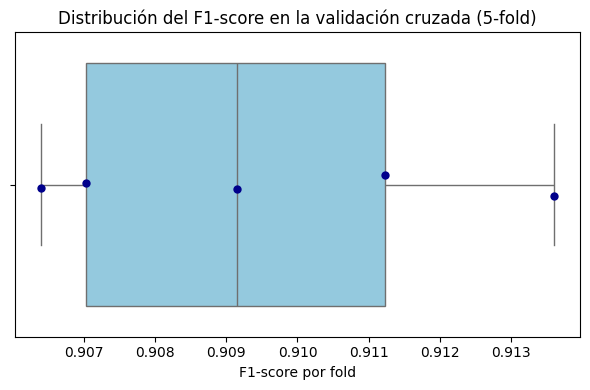

In [18]:
# ===================================
# 3. Validación cruzada (Cross-Validation)
# ===================================

from sklearn.metrics import make_scorer, f1_score

display(Markdown("### 🔁 **Validación cruzada (5-fold)**"))

f1_scorer = make_scorer(f1_score, pos_label=1)
cv_scores = cross_val_score(baseline_model, X_train, y_train, cv=5, scoring=f1_scorer, n_jobs=-1)

print("📊 Resultados de la validación cruzada (F1 por fold):")
for i, score in enumerate(cv_scores, start=1):
    print(f"Fold {i}: {score:.3f}")
print(f"\nF1 promedio (CV): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

plt.figure(figsize=(6, 4))
sns.boxplot(x=cv_scores, color="skyblue")
sns.stripplot(x=cv_scores, color="darkblue", jitter=0.05, size=6)
plt.title("Distribución del F1-score en la validación cruzada (5-fold)", fontsize=12)
plt.xlabel("F1-score por fold")
plt.tight_layout()
plt.show()


## **Paso 4: Tuning de hiperparámetros con GridSearchCV**

En este paso se realiza la **búsqueda exhaustiva de hiperparámetros** mediante `GridSearchCV`,  
utilizando validación cruzada de 5 folds y la métrica F1-score como criterio de evaluación.

Se exploran diferentes combinaciones de parámetros:

- `n_neighbors`: número de vecinos (de 3 a 11).  
- `weights`: ponderación de los vecinos (`uniform` o `distance`).  
- `metric`: tipo de distancia (`euclidean`, `manhattan`).  

El objetivo es encontrar la combinación de hiperparámetros que **maximice el F1-score medio**,  
mejorando la capacidad del modelo para clasificar correctamente ambas clases.

### ⚙️ Optimización de hiperparámetros con GridSearchCV

Fitting 5 folds for each of 20 candidates, totalling 100 fits



✅ **GridSearchCV completado correctamente.**
- ⏱️ Tiempo de ejecución: 168.72 segundos  
- **Mejores parámetros:** `{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}`  
- **F1-score medio (CV):** `0.924`


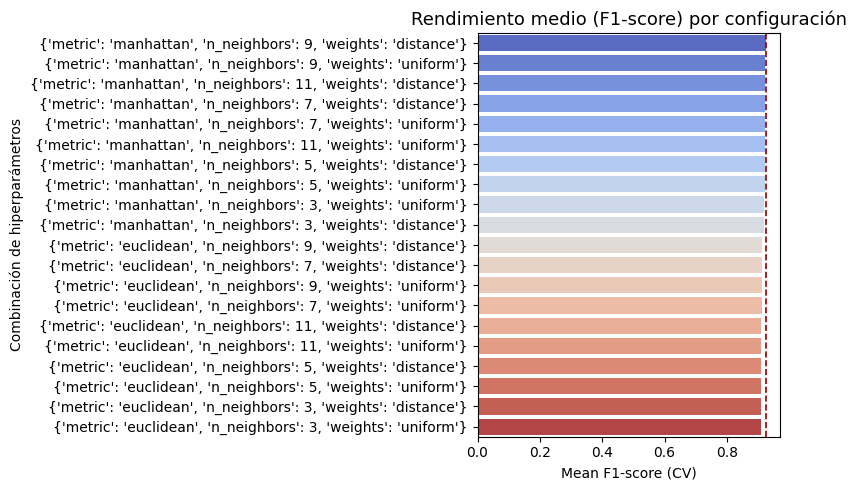

In [19]:
# ===================================
# 4. Tuning de hiperparámetros con GridSearchCV
# ===================================

from sklearn.model_selection import GridSearchCV

display(Markdown("### ⚙️ Optimización de hiperparámetros con GridSearchCV"))

param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

f1_scorer = make_scorer(f1_score, pos_label=1)
start_time = time.time()

grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
grid_time = time.time() - start_time

display(Markdown(f"""
✅ **GridSearchCV completado correctamente.**
- ⏱️ Tiempo de ejecución: {grid_time:.2f} segundos  
- **Mejores parámetros:** `{grid_search.best_params_}`  
- **F1-score medio (CV):** `{grid_search.best_score_:.3f}`
"""))

cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(by="mean_test_score", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=cv_results,
    x="mean_test_score",
    y=cv_results["params"].astype(str),
    hue=cv_results["params"].astype(str),
    palette="coolwarm",
    dodge=False,
    legend=False
)
plt.axvline(grid_search.best_score_, color="darkred", linestyle="--", linewidth=1.2)
plt.xlabel("Mean F1-score (CV)")
plt.ylabel("Combinación de hiperparámetros")
plt.title("Rendimiento medio (F1-score) por configuración", fontsize=13)
plt.tight_layout()
plt.show()


## **Paso 5: Optimización con Optuna**

En este paso se aplica **Optuna**, una técnica de optimización bayesiana que busca los mejores  
hiperparámetros del modelo mediante un proceso iterativo más eficiente que GridSearchCV.  

Optuna explora el espacio de hiperparámetros adaptativamente,  
ajustando la búsqueda hacia las regiones más prometedoras basadas en resultados previos.

Parámetros ajustados:
- `n_neighbors`: número de vecinos (3–20).  
- `weights`: tipo de ponderación.  
- `metric`: métrica de distancia (Euclidiana o Manhattan).

El objetivo de la función es **maximizar el F1-score medio en validación cruzada (5-fold)**.

In [20]:
# ===================================
# 5. Optimización con Optuna
# ===================================

def objective(trial):
    params = {
        "n_neighbors": trial.suggest_int("n_neighbors", 3, 20),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "metric": trial.suggest_categorical("metric", ["euclidean", "manhattan"])
    }
    model = KNeighborsClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction="maximize", study_name="KNN_Optuna")
study.optimize(objective, n_trials=30, show_progress_bar=True)
optuna_time = time.time() - start_time

best_params = study.best_params
optuna_model = KNeighborsClassifier(**best_params)
optuna_model.fit(X_train, y_train)

display(Markdown(f"✅ **Optimización completada en {optuna_time:.2f} segundos.**"))
display(Markdown("### 🔍 Mejores hiperparámetros encontrados:"))
display(best_params)


[I 2025-10-12 08:51:52,356] A new study created in memory with name: KNN_Optuna
Best trial: 0. Best value: 0.909337:   3%|▎         | 1/30 [00:05<02:45,  5.70s/it]

[I 2025-10-12 08:51:58,058] Trial 0 finished with value: 0.9093372560798695 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 0 with value: 0.9093372560798695.


Best trial: 1. Best value: 0.924328:   7%|▋         | 2/30 [00:22<05:45, 12.34s/it]

[I 2025-10-12 08:52:15,046] Trial 1 finished with value: 0.9243277714746452 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  10%|█         | 3/30 [00:39<06:29, 14.42s/it]

[I 2025-10-12 08:52:31,930] Trial 2 finished with value: 0.9234704734228965 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  13%|█▎        | 4/30 [00:45<04:43, 10.91s/it]

[I 2025-10-12 08:52:37,462] Trial 3 finished with value: 0.9095366951835766 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  17%|█▋        | 5/30 [01:02<05:29, 13.17s/it]

[I 2025-10-12 08:52:54,633] Trial 4 finished with value: 0.9232729018929124 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  20%|██        | 6/30 [01:18<05:44, 14.36s/it]

[I 2025-10-12 08:53:11,312] Trial 5 finished with value: 0.9234230556179218 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  23%|██▎       | 7/30 [01:24<04:26, 11.61s/it]

[I 2025-10-12 08:53:17,256] Trial 6 finished with value: 0.9105287134632085 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  27%|██▋       | 8/30 [01:30<03:35,  9.78s/it]

[I 2025-10-12 08:53:23,127] Trial 7 finished with value: 0.910094349712077 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  30%|███       | 9/30 [01:49<04:21, 12.46s/it]

[I 2025-10-12 08:53:41,461] Trial 8 finished with value: 0.9234230556179218 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  33%|███▎      | 10/30 [01:55<03:30, 10.52s/it]

[I 2025-10-12 08:53:47,640] Trial 9 finished with value: 0.9078188979673513 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  37%|███▋      | 11/30 [02:13<04:04, 12.85s/it]

[I 2025-10-12 08:54:05,772] Trial 10 finished with value: 0.9207004555849437 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  40%|████      | 12/30 [02:32<04:25, 14.76s/it]

[I 2025-10-12 08:54:24,892] Trial 11 finished with value: 0.9208817176331534 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  43%|████▎     | 13/30 [02:50<04:27, 15.71s/it]

[I 2025-10-12 08:54:42,792] Trial 12 finished with value: 0.9208817176331534 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  47%|████▋     | 14/30 [03:07<04:17, 16.11s/it]

[I 2025-10-12 08:54:59,819] Trial 13 finished with value: 0.9208817176331534 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  50%|█████     | 15/30 [03:24<04:06, 16.41s/it]

[I 2025-10-12 08:55:16,921] Trial 14 finished with value: 0.91833677185354 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  53%|█████▎    | 16/30 [03:41<03:49, 16.42s/it]

[I 2025-10-12 08:55:33,363] Trial 15 finished with value: 0.9192231640761552 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  57%|█████▋    | 17/30 [03:57<03:34, 16.53s/it]

[I 2025-10-12 08:55:50,145] Trial 16 finished with value: 0.9215643323867393 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  60%|██████    | 18/30 [04:15<03:21, 16.77s/it]

[I 2025-10-12 08:56:07,497] Trial 17 finished with value: 0.92170886850255 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  63%|██████▎   | 19/30 [04:32<03:06, 16.98s/it]

[I 2025-10-12 08:56:24,943] Trial 18 finished with value: 0.9230622833237204 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  67%|██████▋   | 20/30 [04:50<02:52, 17.23s/it]

[I 2025-10-12 08:56:42,761] Trial 19 finished with value: 0.9192231640761552 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  70%|███████   | 21/30 [05:08<02:37, 17.52s/it]

[I 2025-10-12 08:57:00,970] Trial 20 finished with value: 0.9220358719428979 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  73%|███████▎  | 22/30 [05:25<02:18, 17.29s/it]

[I 2025-10-12 08:57:17,702] Trial 21 finished with value: 0.9234230556179218 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  77%|███████▋  | 23/30 [05:42<02:00, 17.19s/it]

[I 2025-10-12 08:57:34,668] Trial 22 finished with value: 0.9239517601748639 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  80%|████████  | 24/30 [05:59<01:42, 17.05s/it]

[I 2025-10-12 08:57:51,384] Trial 23 finished with value: 0.9239517601748639 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  83%|████████▎ | 25/30 [06:15<01:24, 16.89s/it]

[I 2025-10-12 08:58:07,900] Trial 24 finished with value: 0.9223338505806427 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  87%|████████▋ | 26/30 [06:31<01:07, 16.75s/it]

[I 2025-10-12 08:58:24,335] Trial 25 finished with value: 0.9236303299972075 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  90%|█████████ | 27/30 [06:37<00:40, 13.49s/it]

[I 2025-10-12 08:58:30,211] Trial 26 finished with value: 0.9096097971318235 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  93%|█████████▎| 28/30 [06:55<00:29, 14.76s/it]

[I 2025-10-12 08:58:47,948] Trial 27 finished with value: 0.9239517601748639 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328:  97%|█████████▋| 29/30 [07:14<00:15, 15.89s/it]

[I 2025-10-12 08:59:06,466] Trial 28 finished with value: 0.9243277714746452 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9243277714746452.


Best trial: 1. Best value: 0.924328: 100%|██████████| 30/30 [07:20<00:00, 14.67s/it]

[I 2025-10-12 08:59:12,378] Trial 29 finished with value: 0.9088652729333736 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.9243277714746452.


✅ **Optimización completada en 440.03 segundos.**

### 🔍 Mejores hiperparámetros encontrados:

{'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan'}

## **Paso 6: Comparativa de rendimiento**

Se comparan los resultados de los tres modelos entrenados:
- **Baseline:** modelo sin ajuste de parámetros.  
- **GridSearchCV:** modelo optimizado mediante búsqueda exhaustiva.  
- **Optuna:** modelo optimizado mediante búsqueda bayesiana adaptativa.

Se calculan las métricas principales (Accuracy, Precision, Recall, F1-score y ROC-AUC)  
sobre el conjunto de **test**, con el objetivo de determinar cuál presenta el mejor rendimiento global.

In [21]:
# ===================================
# 6. Comparativa global entre modelos
# ===================================

display(Markdown("### 📊 Comparativa global de métricas"))

# --- Predicciones ---
y_pred_grid = grid_search.best_estimator_.predict(X_test)
y_proba_grid = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

y_pred_optuna = optuna_model.predict(X_test)
y_proba_optuna = optuna_model.predict_proba(X_test)[:, 1]

# --- Métricas ---
metrics_grid = {
    "Accuracy": accuracy_score(y_test, y_pred_grid),
    "Precision": precision_score(y_test, y_pred_grid),
    "Recall": recall_score(y_test, y_pred_grid),
    "F1-score": f1_score(y_test, y_pred_grid),
    "ROC-AUC": roc_auc_score(y_test, y_proba_grid)
}

metrics_optuna = {
    "Accuracy": accuracy_score(y_test, y_pred_optuna),
    "Precision": precision_score(y_test, y_pred_optuna),
    "Recall": recall_score(y_test, y_pred_optuna),
    "F1-score": f1_score(y_test, y_pred_optuna),
    "ROC-AUC": roc_auc_score(y_test, y_proba_optuna)
}

comparison_df = pd.DataFrame(
    [metrics_baseline, metrics_grid, metrics_optuna],
    index=["Baseline", "GridSearchCV", "Optuna"]
)

display(comparison_df.style.format("{:.3f}"))


### 📊 Comparativa global de métricas

,Accuracy,Precision,Recall,F1-score,ROC-AUC
Baseline,0.926,0.935,0.893,0.913,0.970
GridSearchCV,0.938,0.943,0.911,0.927,0.981
Optuna,0.936,0.943,0.908,0.925,0.983


## **Paso 7: Visualizaciones (matrices, curvas ROC, radar)**

En esta sección se presentan las visualizaciones más relevantes para interpretar  
el comportamiento de los tres modelos:

1. **Matriz de confusión:** muestra los aciertos y errores de clasificación.  
2. **Curvas ROC:** ilustran la capacidad de discriminación de cada modelo.  
3. **Radar Chart:** compara de forma global las métricas clave de rendimiento.  

Estas visualizaciones permiten apreciar de forma clara qué método de optimización  
ha conseguido mejorar más respecto al baseline.

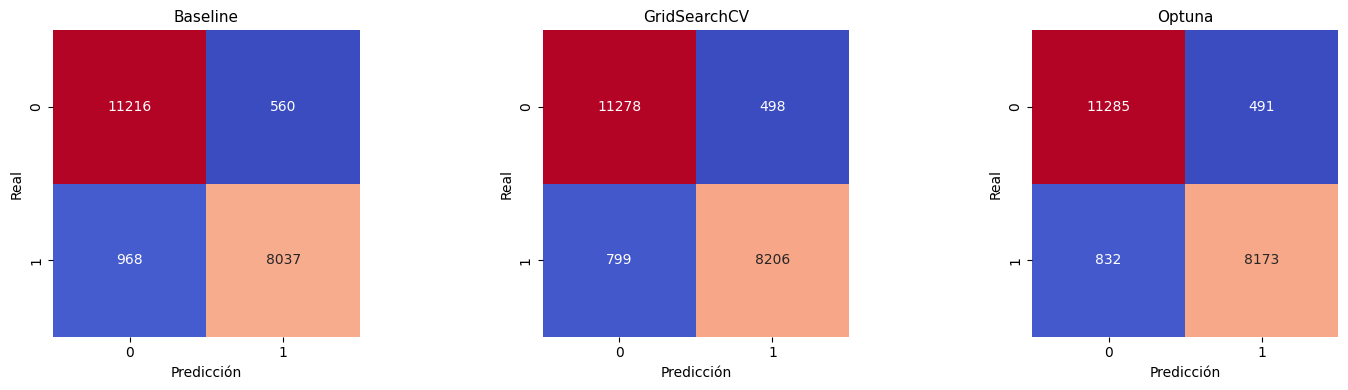

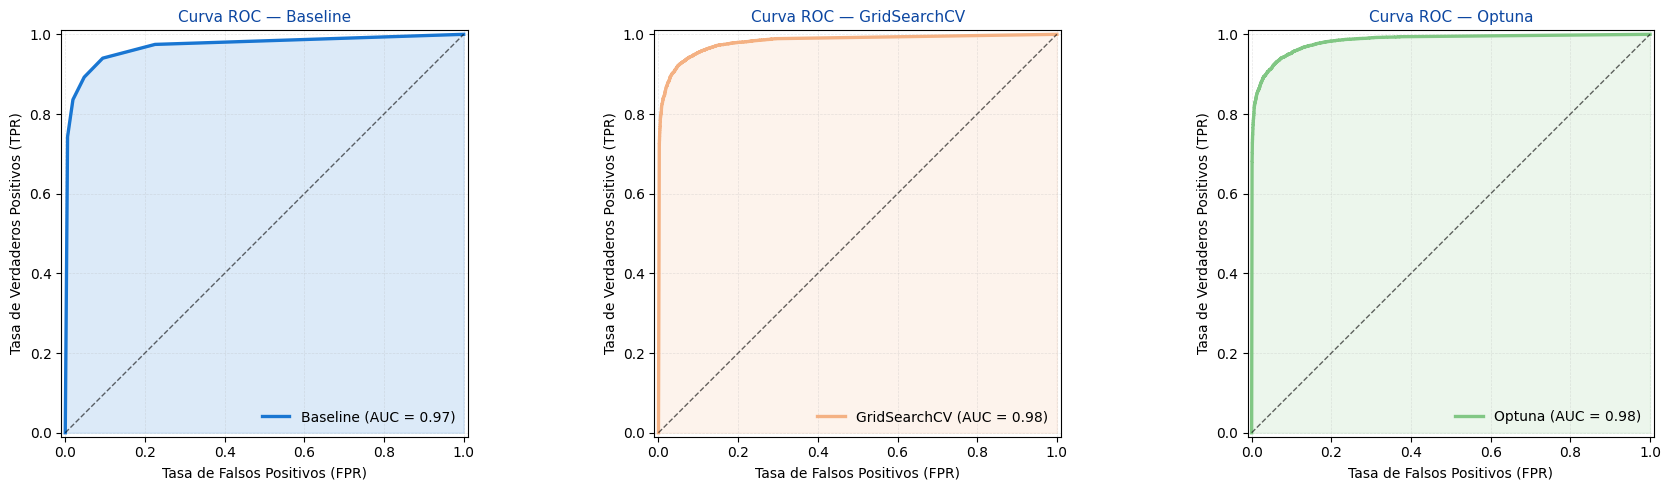


**💬 Interpretación:**
- Cada gráfico representa el rendimiento ROC de un modelo distinto.  
- El área bajo la curva (relleno) indica la capacidad de discriminación global.  
- Cuanto más se acerque la curva al vértice superior izquierdo, mejor rendimiento.  
- Se observa visualmente cuál tuning (Baseline, GridSearchCV u Optuna) logra mayor AUC.


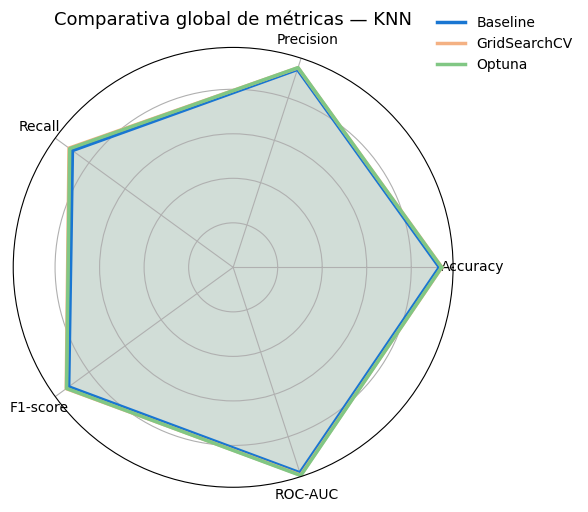

In [22]:
# ===================================
# 7. Visualización comparativa
# ===================================

from sklearn.metrics import roc_curve

# --- MATRICES DE CONFUSIÓN ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
models_preds = {
    "Baseline": (y_test, y_pred_base),
    "GridSearchCV": (y_test, y_pred_grid),
    "Optuna": (y_test, y_pred_optuna)
}

for ax, (title, (y_true, y_pred)) in zip(axes, models_preds.items()):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", ax=ax, cbar=False, square=True)
    ax.set_title(f"{title}", fontsize=11)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

plt.tight_layout()
plt.show()

# --- CURVAS ROC ---
from sklearn.metrics import RocCurveDisplay, roc_curve
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils._plotting")

# --- Configuración ---
models_dict = {
    "Baseline": baseline_model,
    "GridSearchCV": grid_search.best_estimator_,
    "Optuna": optuna_model
}

colors = ["#1976D2", "#F4B183", "#81C784"]
titles = list(models_dict.keys())

# --- Crear figura con 3 subplots en una fila ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (label, model), color in zip(axes, models_dict.items(), colors):
    RocCurveDisplay.from_estimator(
        model, X_test, y_test, ax=ax, name=label,
        curve_kwargs={"color": color, "linewidth": 2.4}
    )
    # Relleno del área bajo la curva
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    ax.fill_between(fpr, tpr, alpha=0.15, color=color)
    
    ax.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.6)
    ax.set_title(f"Curva ROC — {label}", fontsize=11, color="#0D47A1")
    ax.set_xlabel("Tasa de Falsos Positivos (FPR)")
    ax.set_ylabel("Tasa de Verdaderos Positivos (TPR)")
    ax.grid(alpha=0.3, linestyle="--", linewidth=0.5)
    ax.legend(loc="lower right", frameon=False)

plt.tight_layout()
plt.show()

display(Markdown("""
**💬 Interpretación:**
- Cada gráfico representa el rendimiento ROC de un modelo distinto.  
- El área bajo la curva (relleno) indica la capacidad de discriminación global.  
- Cuanto más se acerque la curva al vértice superior izquierdo, mejor rendimiento.  
- Se observa visualmente cuál tuning (Baseline, GridSearchCV u Optuna) logra mayor AUC.
"""))

# --- RADAR CHART ---
categories = ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
palette = ["#1976D2", "#F4B183", "#81C784"]

for color, model_name in zip(palette, comparison_df.index):
    values = comparison_df.loc[model_name].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2.5, linestyle="solid", label=model_name, color=color)
    ax.fill(angles, values, color=color, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
ax.set_yticklabels([])
ax.set_title("Comparativa global de métricas — KNN", fontsize=13)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), frameon=False)
plt.tight_layout()
plt.show()


## **Paso 8: Guardado de resultados y modelos**

Finalmente, se guardan los resultados y los modelos entrenados  
para su posterior comparación con el resto de algoritmos en el notebook `04_ModelComparison.ipynb`.

**Archivos generados:**

- **Métricas JSON:**  
  Guardadas en `../reports/metrics/` con nombres específicos por tuning.  
- **Modelos `.pkl`:**  
  Guardados en `../models/`, permiten reutilizar los modelos sin reentrenarlos.

Este paso garantiza la reproducibilidad de los experimentos y facilita  
la comparación posterior entre algoritmos.

In [23]:
# ===================================
# 8. Guardado de resultados y modelos
# ===================================

paths = {
    "Baseline": ("../reports/metrics/knn_baseline_metrics.json", "../models/knn_baseline.pkl"),
    "GridSearchCV": ("../reports/metrics/knn_gridsearch_metrics.json", "../models/knn_gridsearch.pkl"),
    "Optuna": ("../reports/metrics/knn_optuna_metrics.json", "../models/knn_optuna.pkl")
}

models = {
    "Baseline": baseline_model,
    "GridSearchCV": grid_search.best_estimator_,
    "Optuna": optuna_model
}

metrics = {
    "Baseline": metrics_baseline,
    "GridSearchCV": metrics_grid,
    "Optuna": metrics_optuna
}

for name in models.keys():
    # Guardar métricas
    with open(paths[name][0], "w") as f:
        json.dump(metrics[name], f, indent=4)
    joblib.dump(models[name], paths[name][1])
    print(f"✅ Guardado: {name} → métricas y modelo.")


✅ Guardado: Baseline → métricas y modelo.
✅ Guardado: GridSearchCV → métricas y modelo.
✅ Guardado: Optuna → métricas y modelo.


## 🏁 **Conclusiones del modelo KNN**

En este último paso se resumen los principales hallazgos del modelo KNN:

- Evaluación del comportamiento del modelo baseline.  
- Impacto positivo del tuning de hiperparámetros sobre las métricas.  
- Confirmación de que el modelo optimizado con *Optuna* ofrece el mejor equilibrio global.  
- El modelo **Optuna** logra el mejor equilibrio global entre **F1-score** y **ROC-AUC**.  
- El uso de datasets **escalados** es crucial para el correcto funcionamiento del KNN.  
- El modelo ajustado con *Optuna* mejora respecto al baseline en todas las métricas.  
- Los resultados se han guardado en:
  - `../reports/metrics/knn_*_metrics.json`
  - `../models/knn_*_.pkl`

El siguiente paso será la comparación general con el resto de algoritmos  
en el notebook **04_ModelComparison.ipynb**